In [ ]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

# !pip3 install scanpy
# !pip3 install leidenalg

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc

In [ ]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [ ]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

In [ ]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

In [ ]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [ ]:
adata

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [ ]:
sc.pp.log1p(adata)

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
adata.raw = adata

In [ ]:
adata = adata[:, adata.var.highly_variable]

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [ ]:
sc.pp.scale(adata, max_value=10)

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
sc.pl.pca(adata, color='CST3')


In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
adata.write(results_file)

In [ ]:
adata

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

In [ ]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

In [ ]:
sc.tl.leiden(adata)

In [ ]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [ ]:
adata.write(results_file)

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
adata.write(results_file)

In [ ]:
# passed 'max_iter=1000' to method call, algorithm did not converge otherwise
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg', max_iter=1000)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [ ]:
adata = sc.read(results_file)

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [ ]:
adata = sc.read(results_file)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [ ]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

In [ ]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

In [ ]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

In [ ]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

In [ ]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);


In [ ]:
adata

In [ ]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

In [ ]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

In [ ]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.5 scipy==1.7.3 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.7


In [4]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

In [5]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


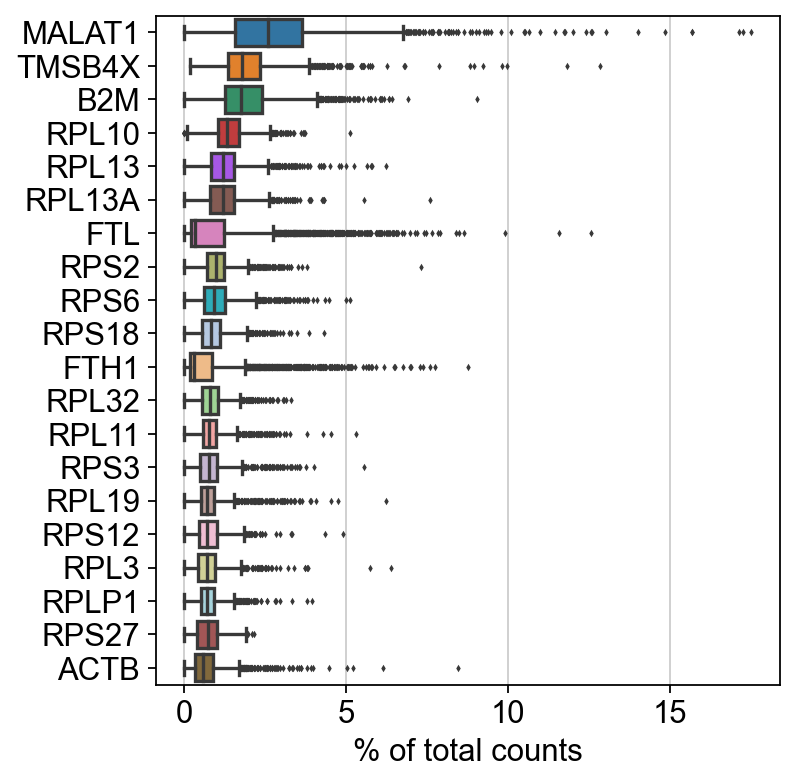

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

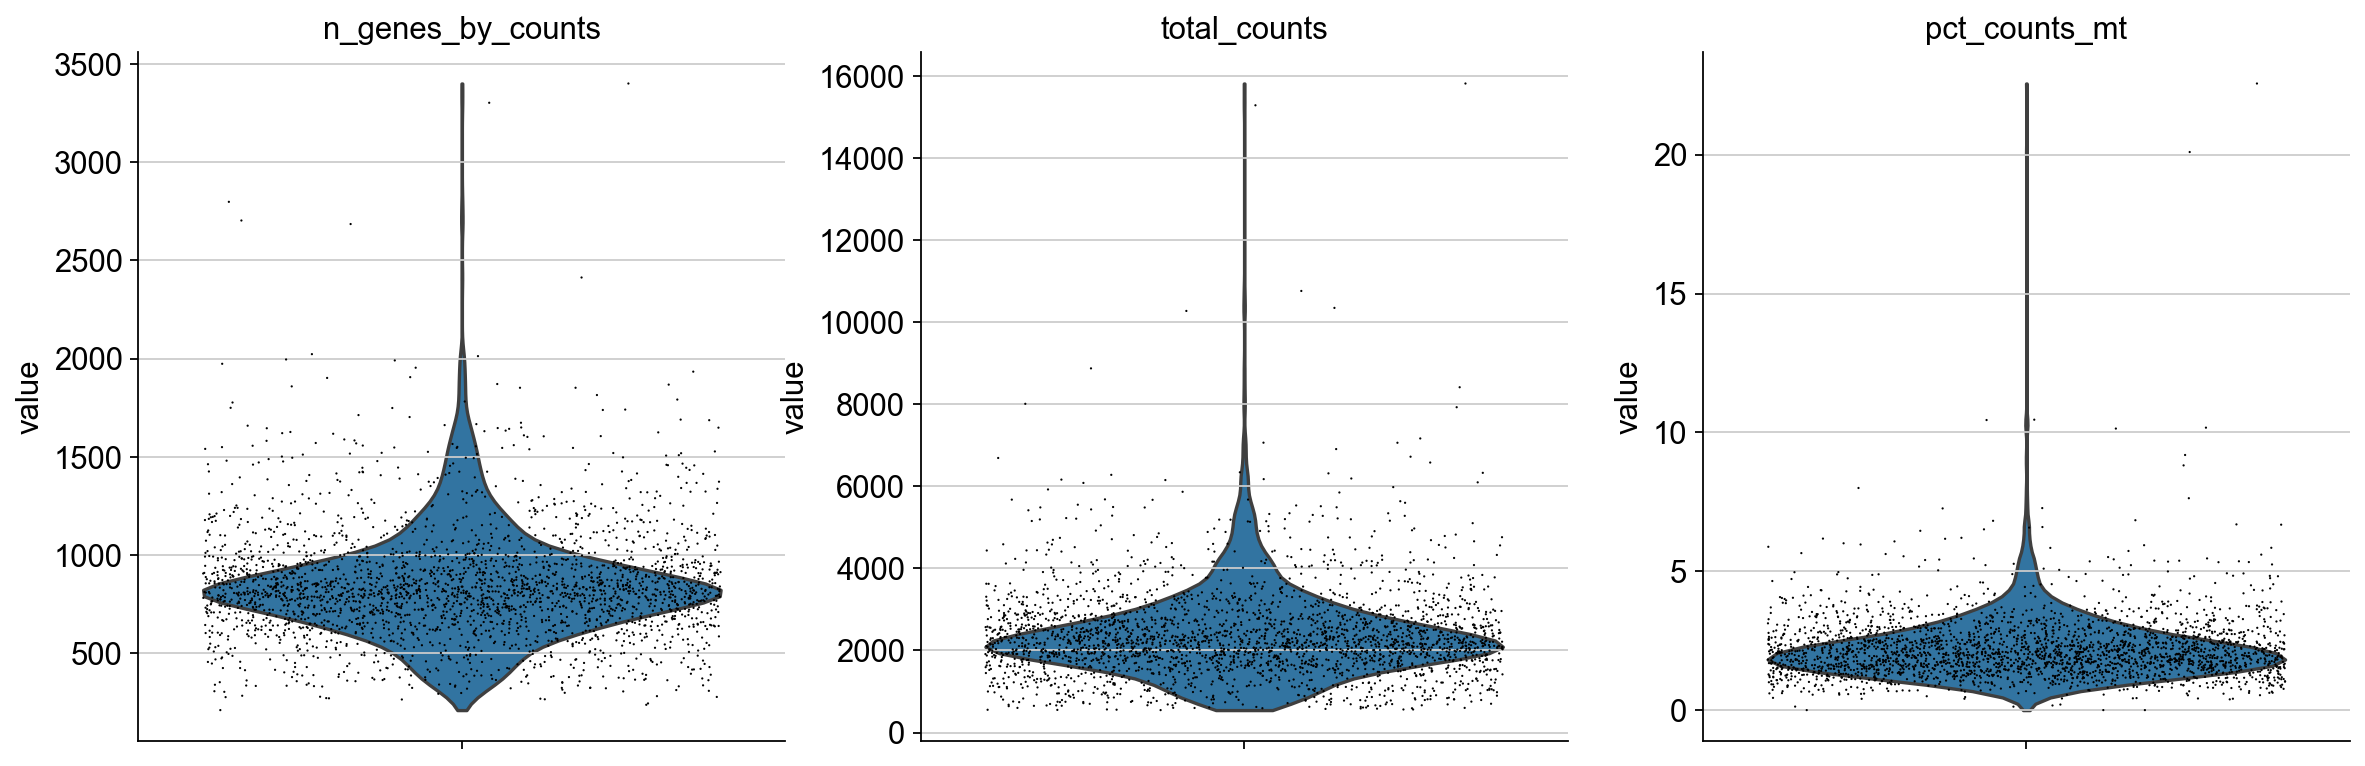

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

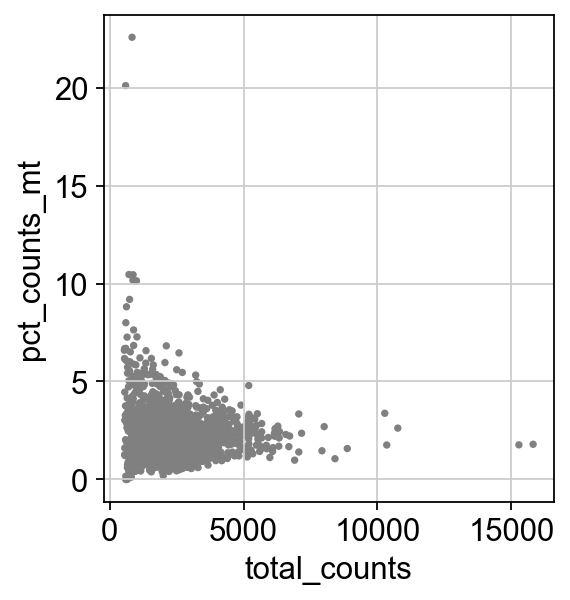

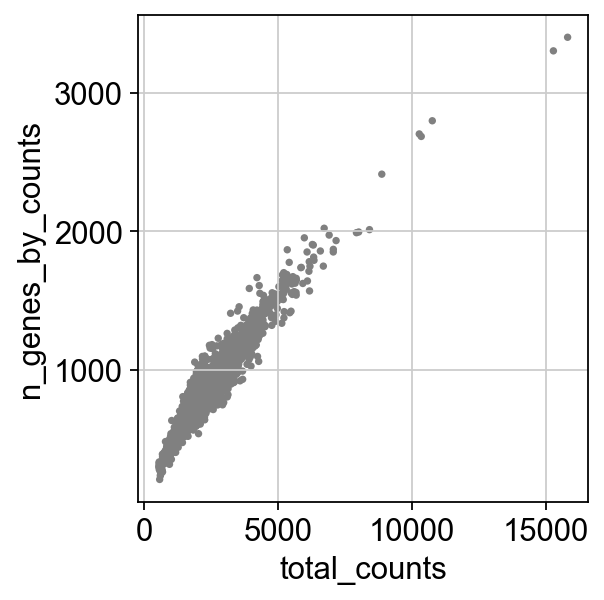

In [12]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [13]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [14]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [15]:
sc.pp.log1p(adata)

In [16]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


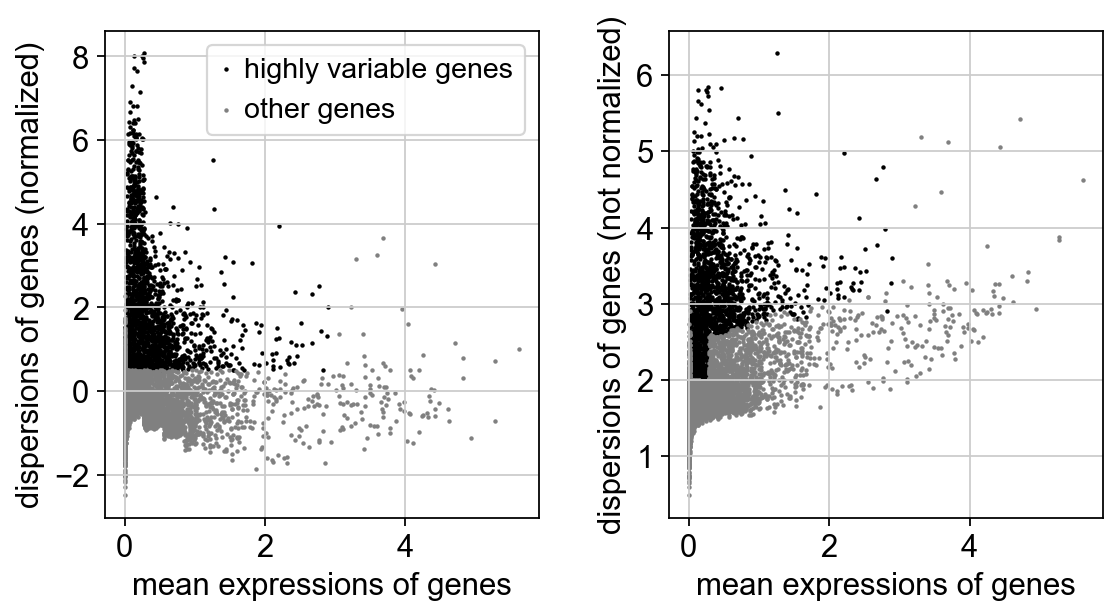

In [17]:
sc.pl.highly_variable_genes(adata)

In [18]:
adata.raw = adata

In [19]:
adata = adata[:, adata.var.highly_variable]

In [20]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:07)


In [21]:
sc.pp.scale(adata, max_value=10)

In [22]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


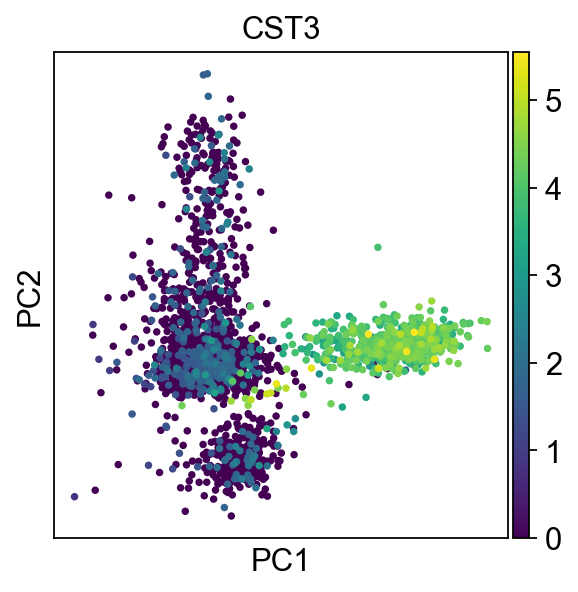

In [23]:
sc.pl.pca(adata, color='CST3')


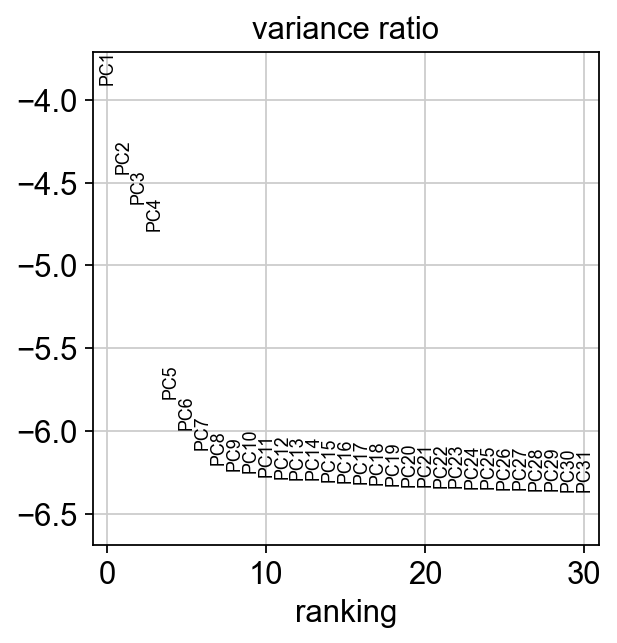

In [24]:
sc.pl.pca_variance_ratio(adata, log=True)

In [25]:
adata.write(results_file)

In [26]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [27]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [28]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


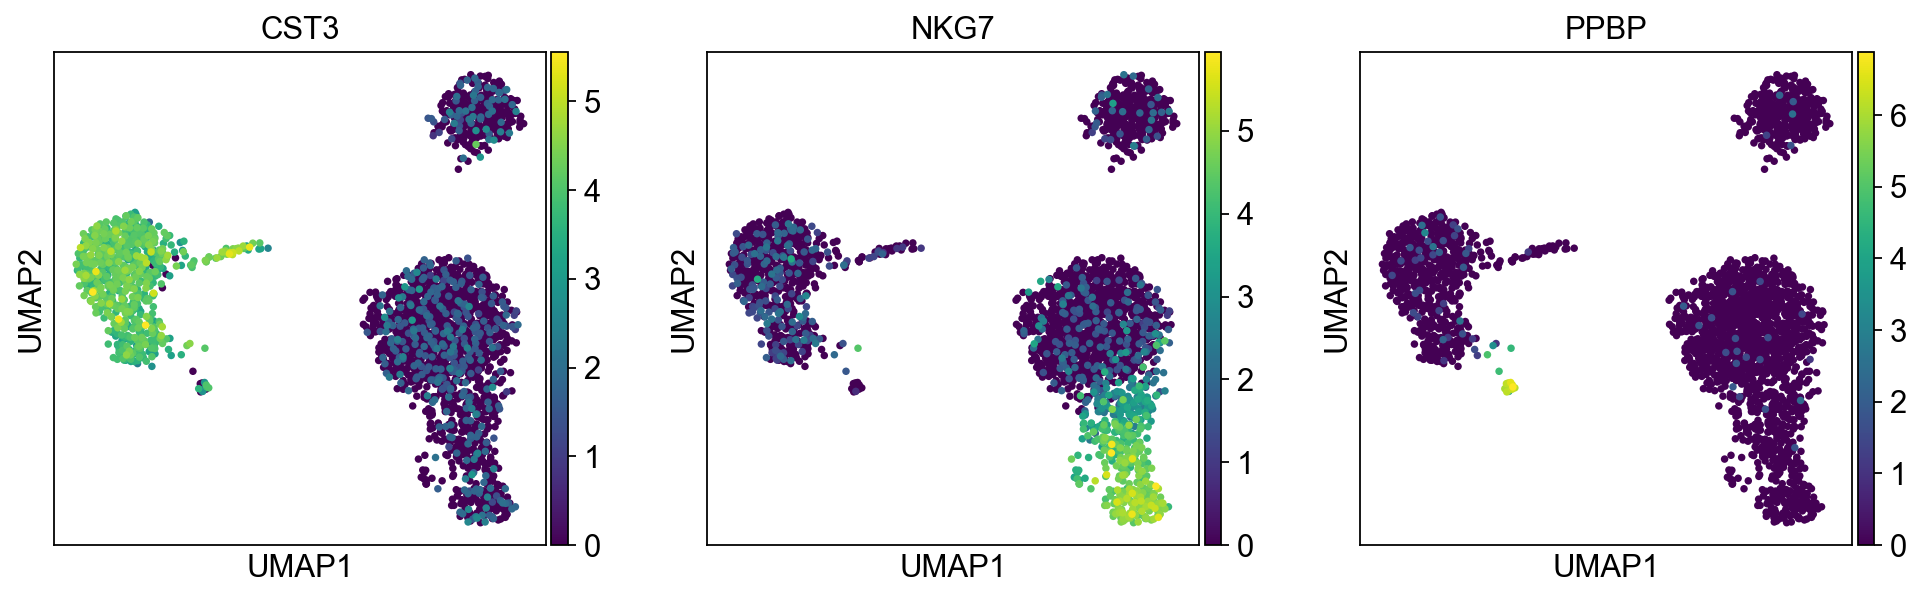

In [29]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

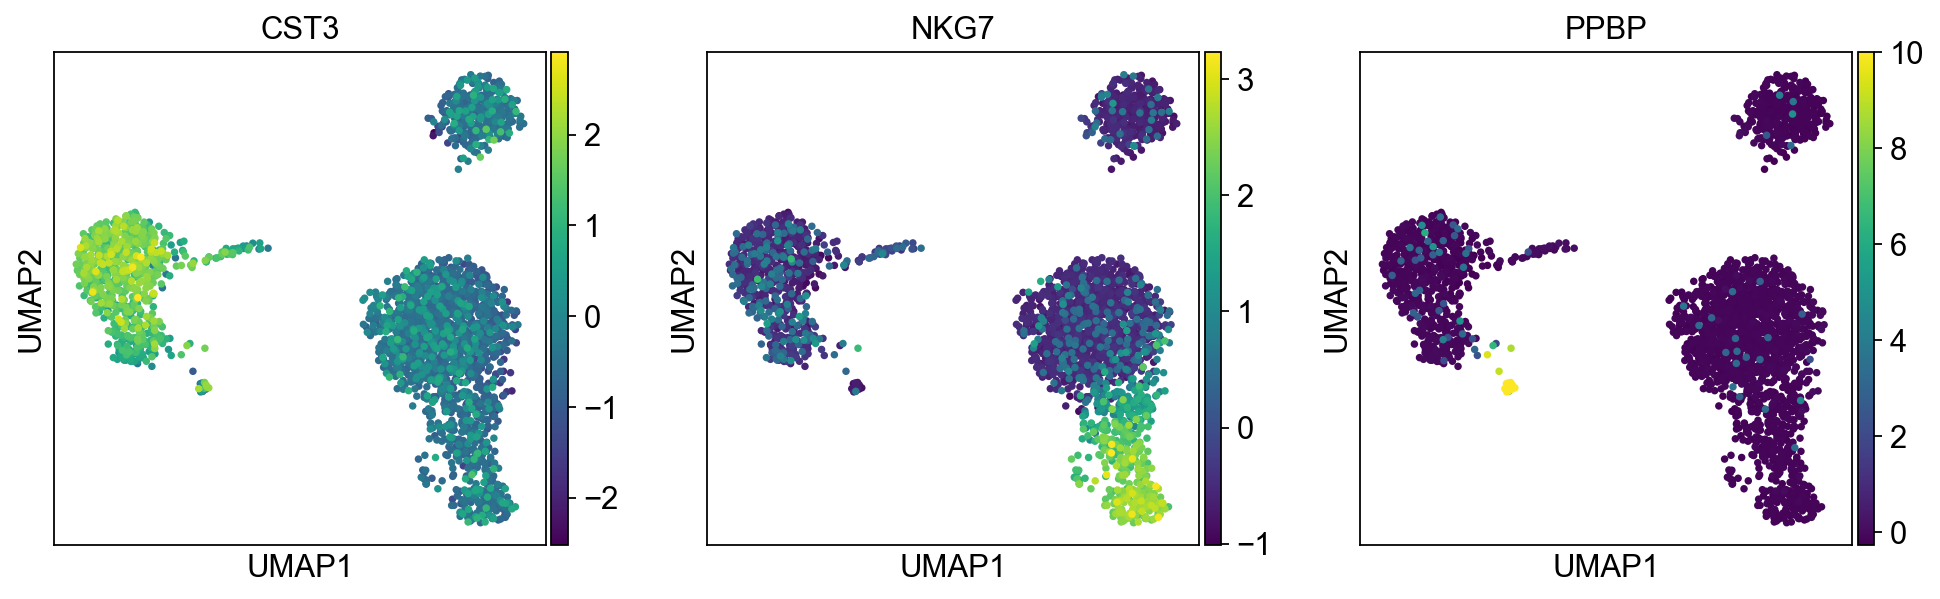

In [30]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

In [31]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


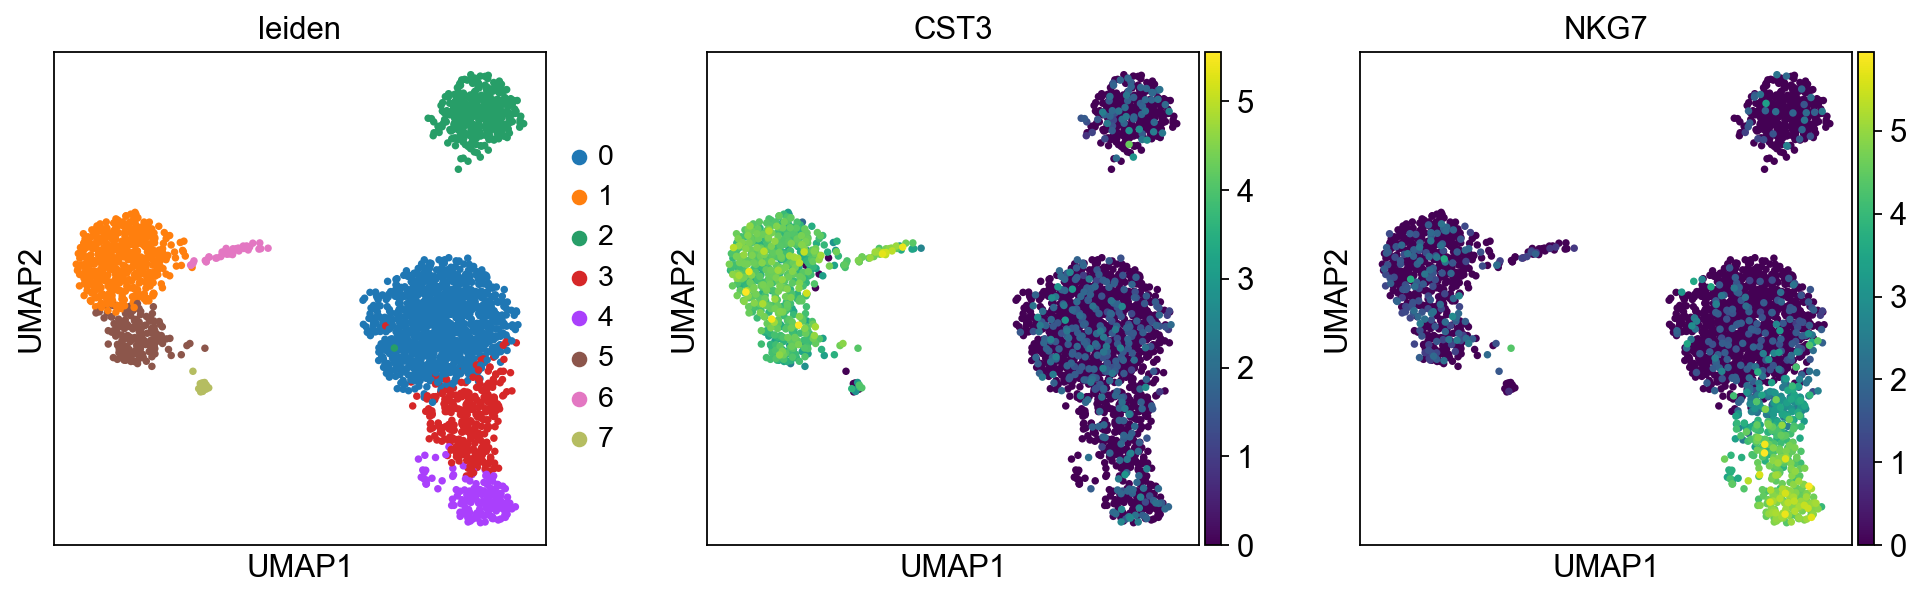

In [32]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [33]:
adata.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


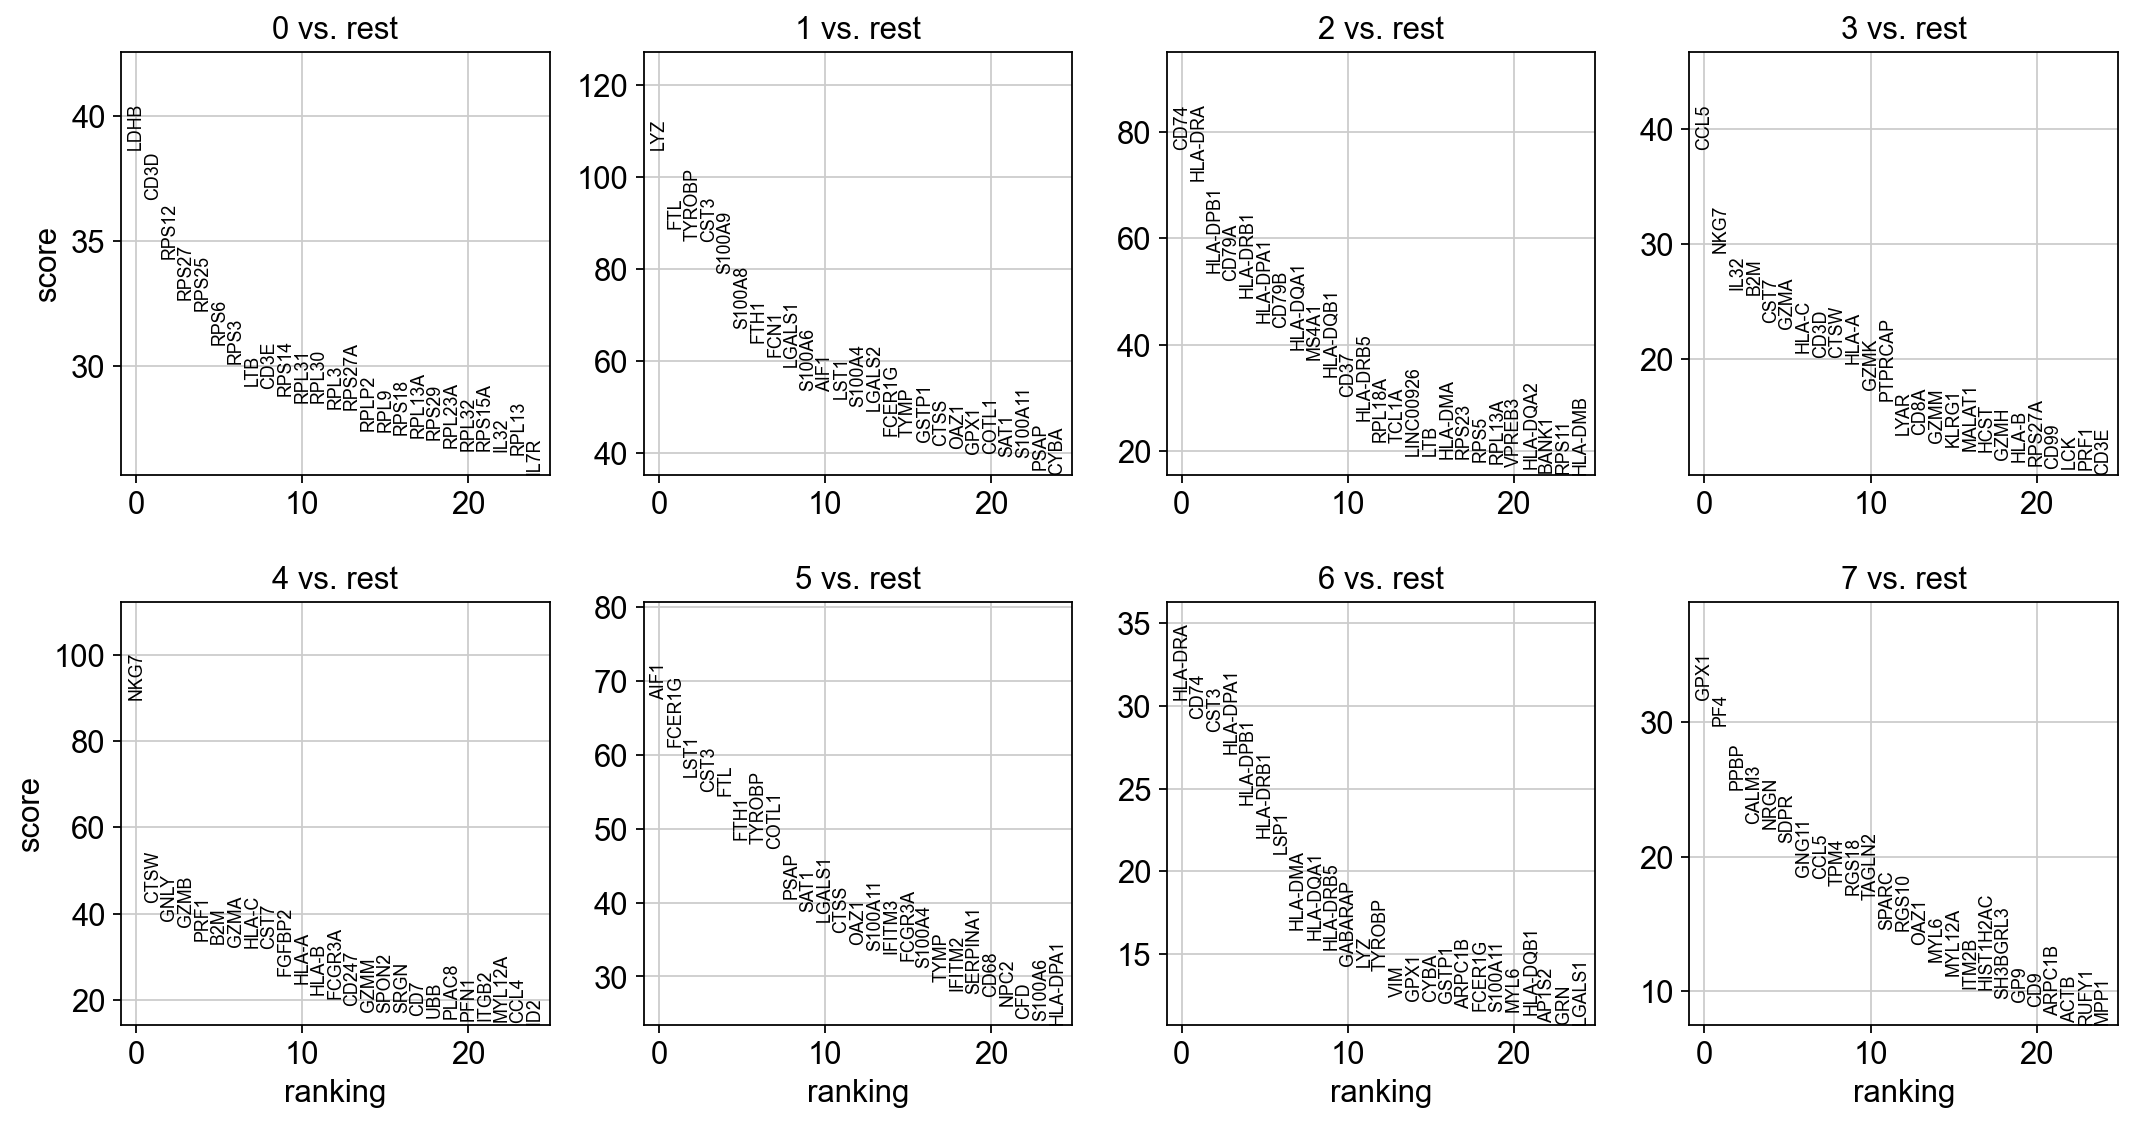

In [34]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [35]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:01)


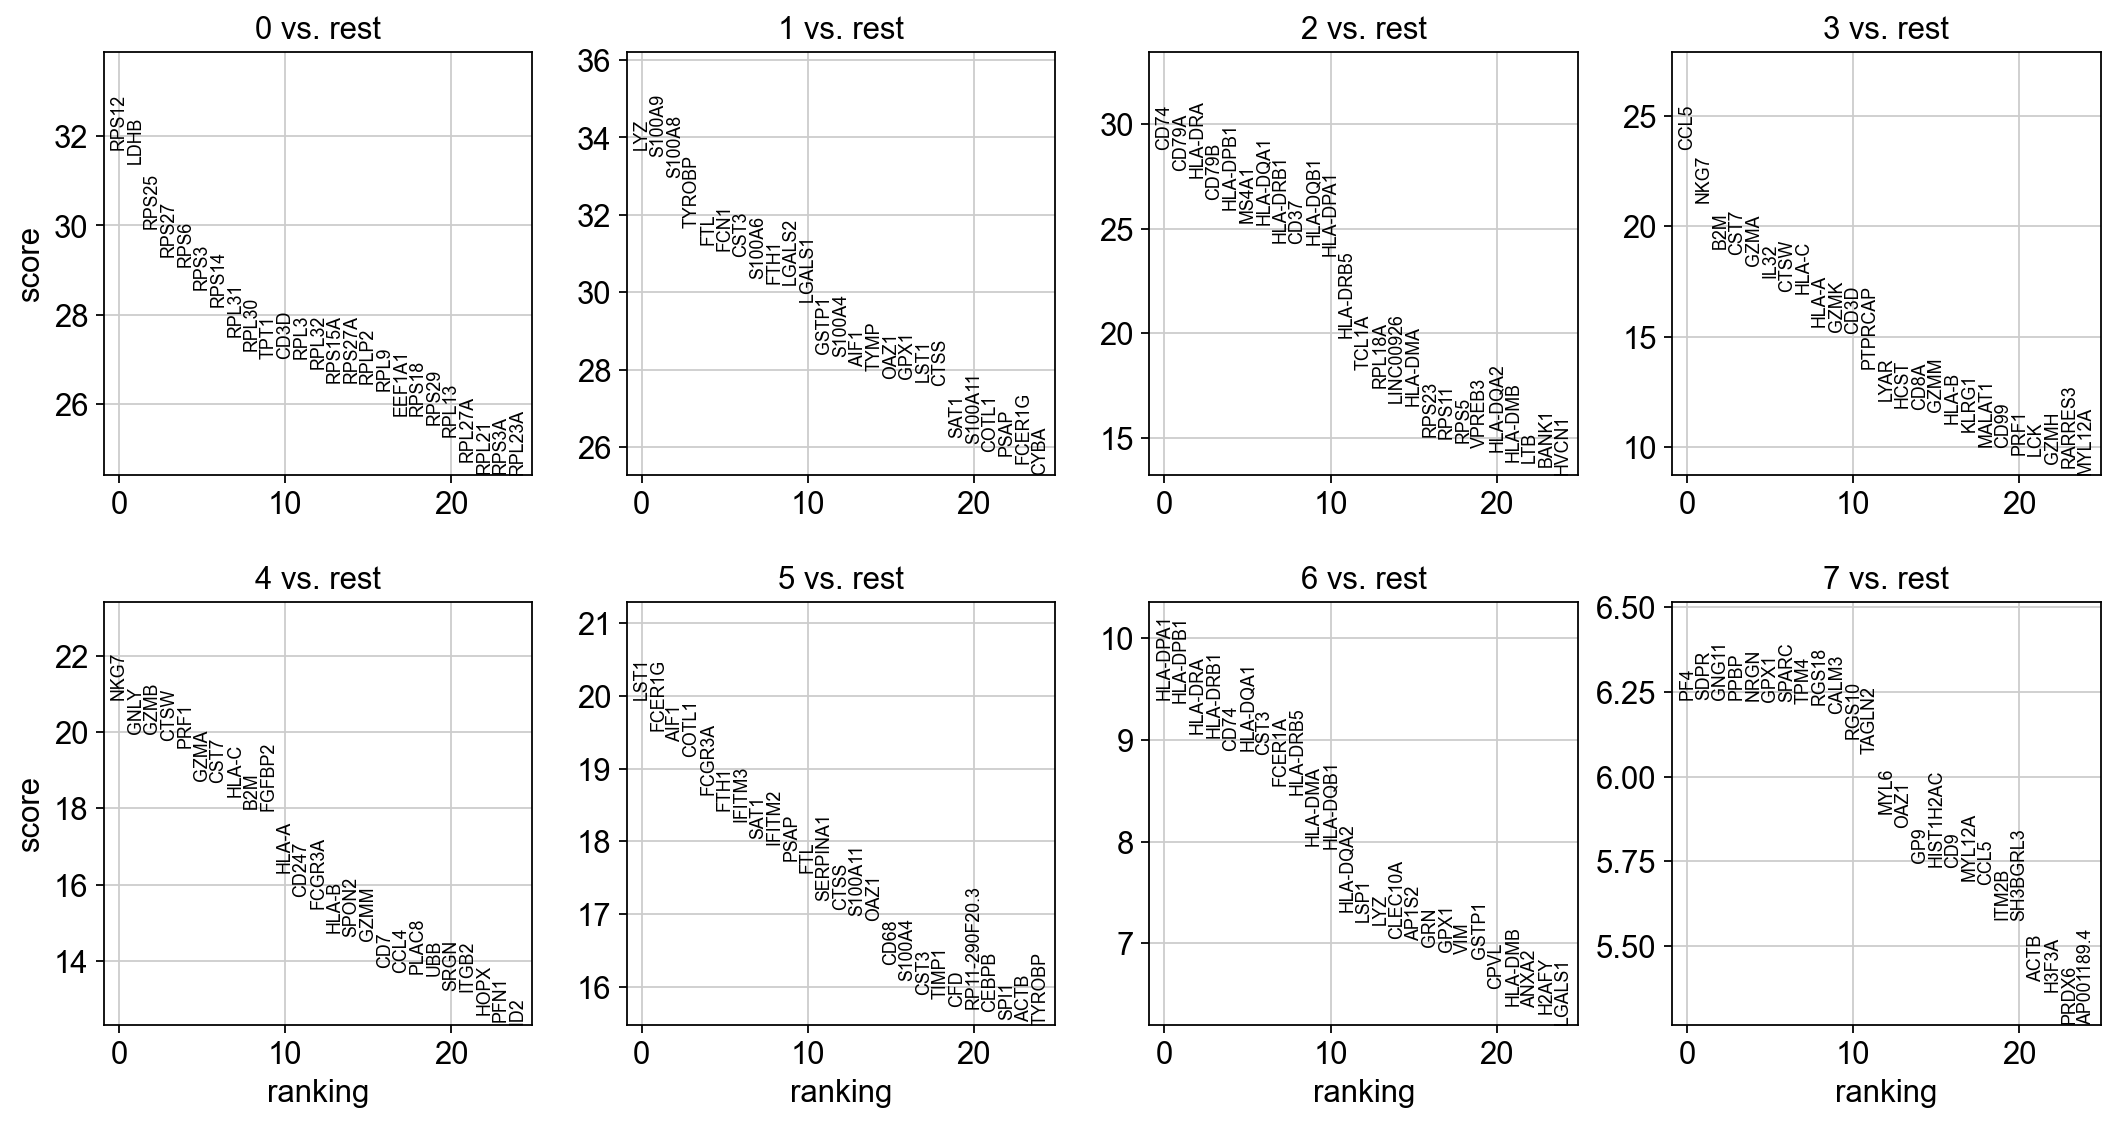

In [36]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [37]:
adata.write(results_file)

ranking genes
    finished (0:00:24)


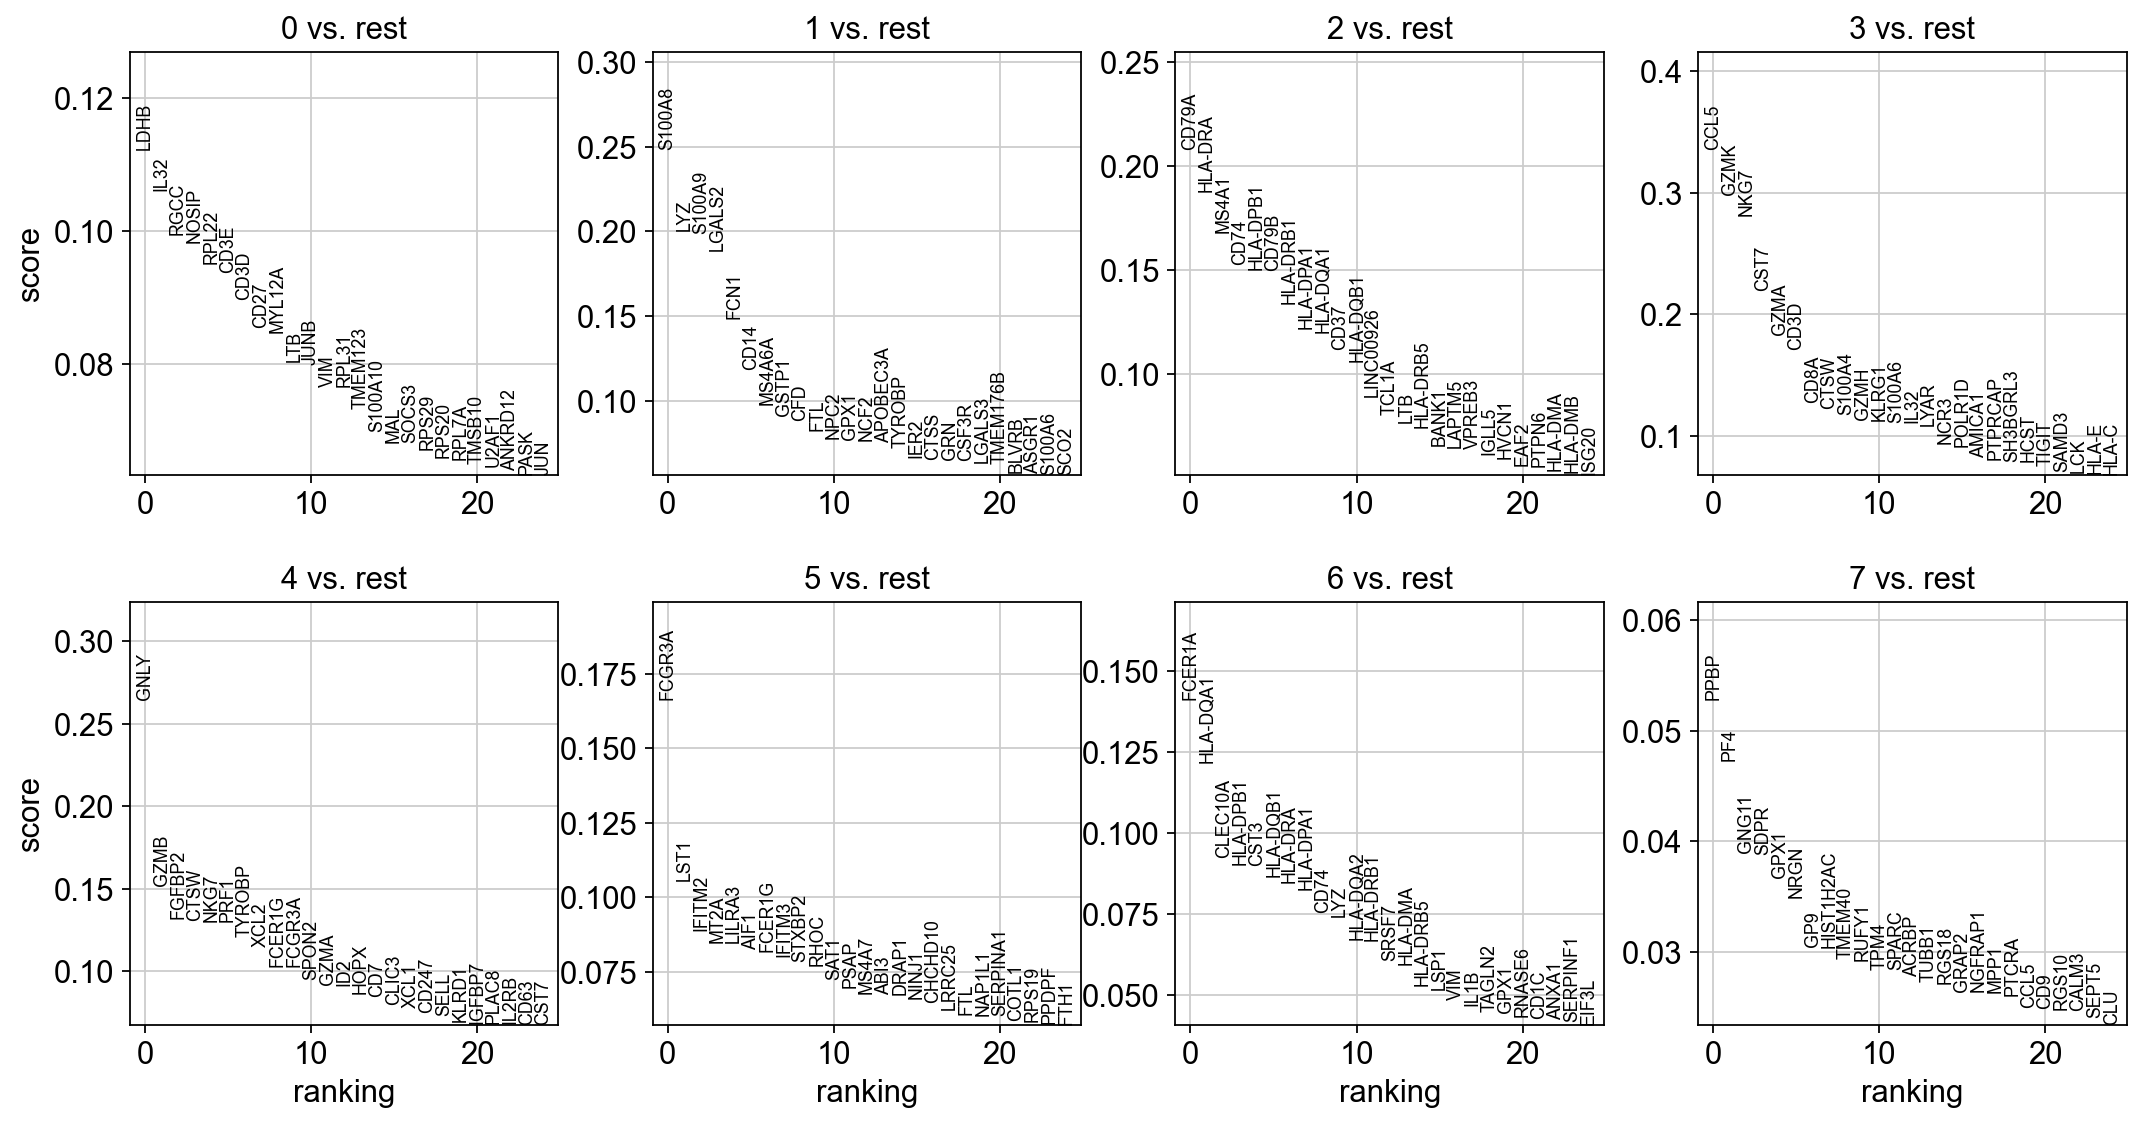

In [39]:
# passed 'max_iter=1000' to method call, algorithm did not converge otherwise
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg', max_iter=1000)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [40]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [41]:
adata = sc.read(results_file)

In [42]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7
0,RPS12,LYZ,CD74,CCL5,NKG7,LST1,HLA-DPA1,PF4
1,LDHB,S100A9,CD79A,NKG7,GNLY,FCER1G,HLA-DPB1,SDPR
2,RPS25,S100A8,HLA-DRA,B2M,GZMB,AIF1,HLA-DRA,GNG11
3,RPS27,TYROBP,CD79B,CST7,CTSW,COTL1,HLA-DRB1,PPBP
4,RPS6,FTL,HLA-DPB1,GZMA,PRF1,FCGR3A,CD74,NRGN


In [43]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,1.422363e-220,LYZ,7.634876e-249,CD74,3.043536e-182,CCL5,7.378907e-122,NKG7,1.203971e-96,LST1,1.322111e-88,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LDHB,2.611358e-216,S100A9,4.626358e-246,CD79A,6.860832e-170,NKG7,9.346712e-99,GNLY,1.257170e-88,FCER1G,6.259712e-85,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,RPS25,7.649135e-197,S100A8,1.622835e-238,HLA-DRA,8.398068e-166,B2M,1.622041e-80,GZMB,1.429027e-88,AIF1,1.348814e-83,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS27,1.087280e-188,TYROBP,2.957652e-220,CD79B,1.171444e-153,CST7,3.688097e-78,CTSW,4.144726e-87,COTL1,5.974694e-82,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,RPS6,5.943575e-186,FTL,2.479195e-214,HLA-DPB1,6.167786e-148,GZMA,4.848390e-74,PRF1,1.692100e-85,FCGR3A,1.392377e-77,CD74,5.853161e-19,NRGN,4.800511e-10


In [44]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

ranking genes


KeyError: 'base'

In [45]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

KeyError: 'names'

In [46]:
adata = sc.read(results_file)

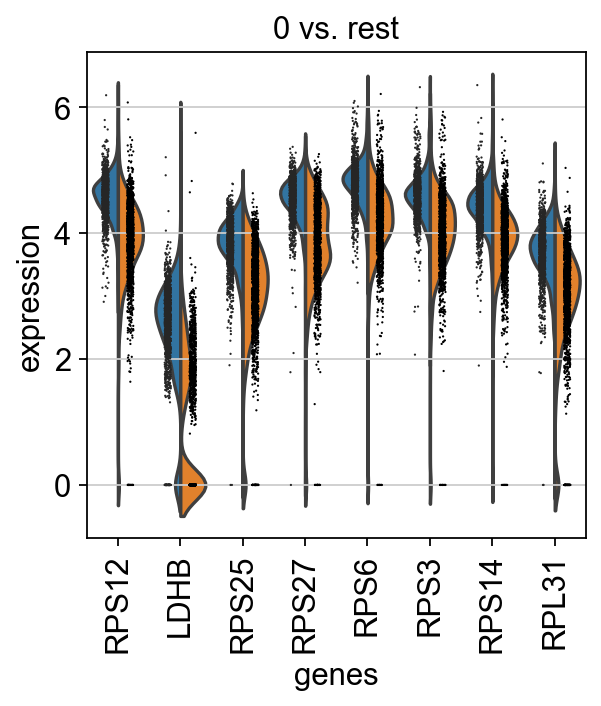

In [47]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

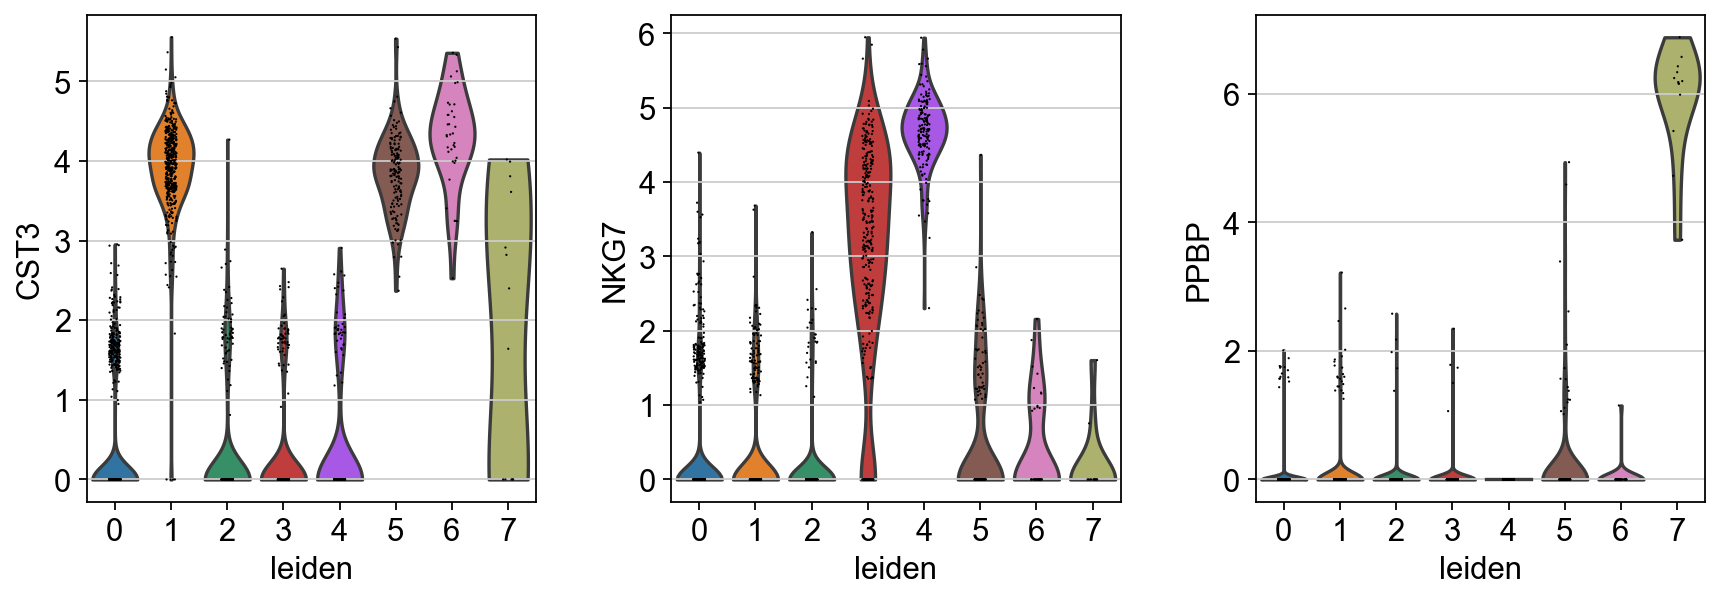

In [48]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

In [49]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


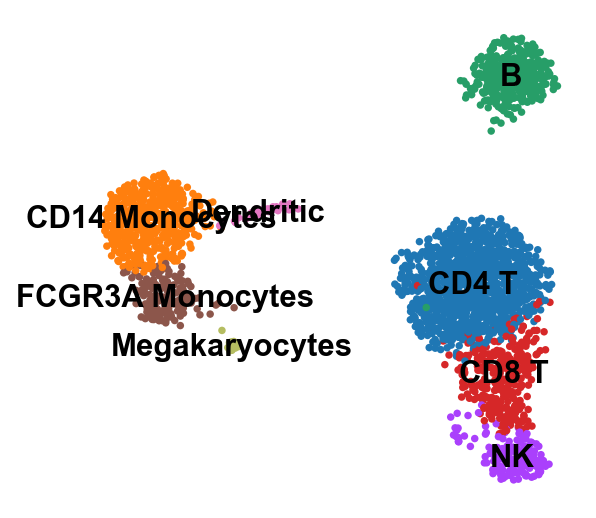

In [50]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

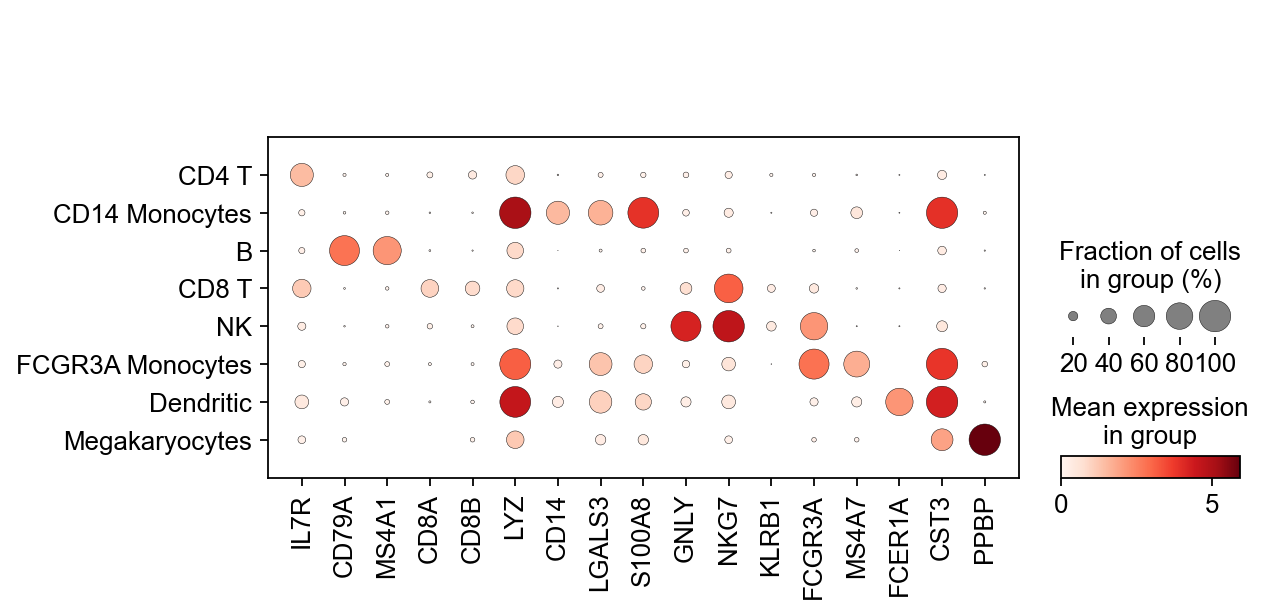

In [51]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

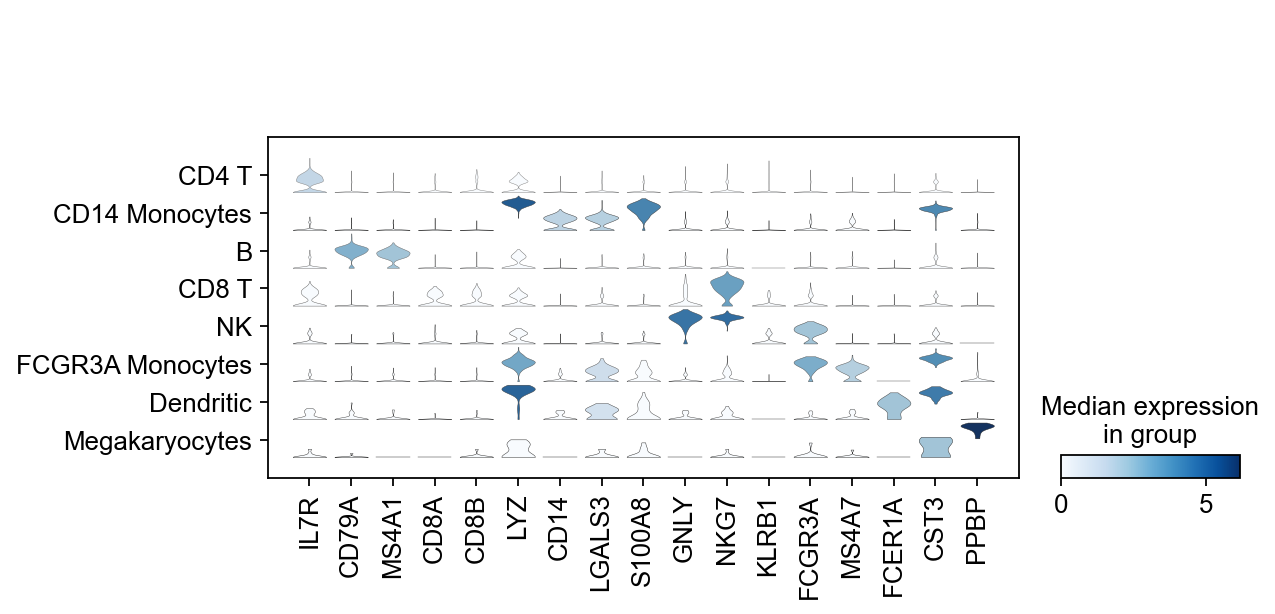

In [52]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);


In [53]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [54]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

In [55]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

In [56]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )